# Deep Learning IndabaX 2021 Hackathon Starter Notebook

## Autonomous Shopper Prediction by Cape AI

Welcome to the starter notebook for the [Deep Learning IndabaX 2021](https://indabax.co.za/) Hackathon! This year, the competition is entitled: Autonomous Shopper Prediction by [Cape AI](https://cape-ai.com/). Below, you will find some useful tips on how to import the competition data into a Python environment and how to fit a basic model to land yourself on the leaderboard!

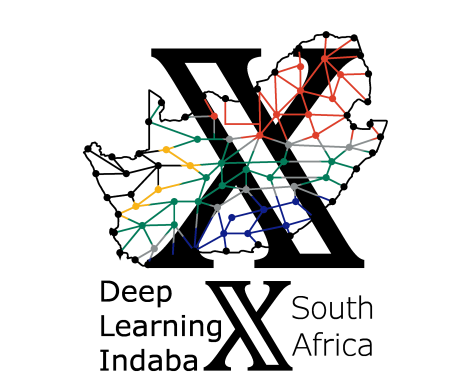

You will be working with data provided by [Cape AI](https://cape-ai.com/)'s [Moonshop](https://moonshoptechnologies.com/). Africa’s first autonomous shopping solution.

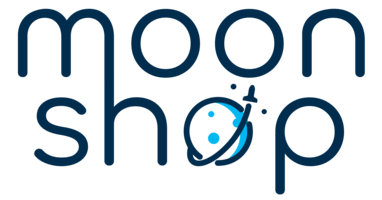

In [15]:
import pandas as pd
import numpy as np

import keras
import sklearn
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

import matplotlib.pyplot as plt

## Importing the Data

We start by reading in the training data and the training target.

In [16]:
# Read in training data
df = pd.read_csv('Train.csv')

In [17]:
# Read in target
target = pd.read_csv('Train_Target.csv')

Next, we create a validation set by randomly selecting 30% of the available training baskets. We do this to ensure there is no data leakage (i.e. footage from a basket existing in both the training and validation sets).

In [18]:
# Create validation set
num_baskets = len(df["Basket Masked"].unique())
test_baskets = int(np.round((0.25)*num_baskets, 0))

# Randomly sample baskets to be in the validation set
rng = np.random.default_rng()
test_baskets = rng.choice(
    df["Basket Masked"].values, test_baskets, replace=False)

# Create training and validation sets
val_mask = np.array(
    [basket in test_baskets for basket in df['Basket Masked']])

X_valid = df[val_mask]
X_valid.drop('Basket Masked', axis=1, inplace=True)

X_train = df[~val_mask]
X_train.drop('Basket Masked', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
y_train = pd.merge(target, X_train['ID'].drop_duplicates(), how='inner')
y_valid = pd.merge(target, X_valid['ID'].drop_duplicates(), how='inner')

# Drop the ID column
X_train.drop('ID', axis=1, inplace=True)
X_valid.drop('ID', axis=1, inplace=True)

y_train = y_train['Target'].values
y_valid = y_valid['Target'].values

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Let's scale (subtract the mean and divide by the standard deviation) each feature in the training and validation sets before training our model.

In [20]:
# Instantiate and fit the scaler
scaler = StandardScaler()
scaler.fit(X_train)

# Scale the datasets with the training mean and std
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

Finally, we prepare the data for sequence modeling by creating the observations of 30 frame sequences.

In [21]:
def block_data(data, n_frames):

    data = np.array(data)
    blocks = int(data.shape[0] / n_frames)

    data = np.array(np.split(data, blocks))

    return data

In [22]:
X_train = block_data(X_train, 30)
X_valid = block_data(X_valid, 30)

Let's print the shapes of the training and validation sets to check that we have achieved the correct data groupings.

In [23]:
print((X_train.shape, y_train.shape))
print((X_valid.shape, y_valid.shape))

((898, 30, 66), (898,))
((444, 30, 66), (444,))


Now, we go on to instantiate, fit, and validate a simple LSTM model to predict whether a take action occured in a given sequence of 30 frames.

## Building a Simple LSTM model

First, we need to build the model architecture.

In [24]:
# Obtain the correct input and output dimensions for the model
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], 1

# Use Keras's Sequential API to build the model architecture
model = keras.models.Sequential()
model.add(keras.layers.LSTM(50, input_shape=(n_timesteps, n_features)))
model.add(keras.layers.Dense(50, activation='relu'))
model.add(keras.layers.Dense(n_outputs, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=[tf.keras.metrics.AUC(num_thresholds=300)])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                23400     
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 26,001
Trainable params: 26,001
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
# Compute class weights
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', [0,1], y_train)
class_weights = {0:class_weights[0], 1:class_weights[1]}

Now we train our model! We will use the validation set to validate our model's performance on out-of-sample data.

In [26]:
_history = model.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid),
                                  batch_size=64, verbose=1, class_weight=class_weights)

# Keep only the training history
history = _history.history

Epoch 1/30
15/15 [==============================] - 6s 41ms/step - loss: 0.6634 - auc: 0.6238 - val_loss: 0.7081 - val_auc: 0.6032
Epoch 2/30
15/15 [==============================] - 0s 9ms/step - loss: 0.6052 - auc: 0.7324 - val_loss: 0.7208 - val_auc: 0.6149
Epoch 3/30
15/15 [==============================] - 0s 8ms/step - loss: 0.5816 - auc: 0.7563 - val_loss: 0.7649 - val_auc: 0.6254
Epoch 4/30
15/15 [==============================] - 0s 8ms/step - loss: 0.5666 - auc: 0.7841 - val_loss: 0.8061 - val_auc: 0.6083
Epoch 5/30
15/15 [==============================] - 0s 11ms/step - loss: 0.5463 - auc: 0.7930 - val_loss: 0.6409 - val_auc: 0.6486
Epoch 6/30
15/15 [==============================] - 0s 8ms/step - loss: 0.5401 - auc: 0.8020 - val_loss: 0.6981 - val_auc: 0.6298
Epoch 7/30
15/15 [==============================] - 0s 8ms/step - loss: 0.5122 - auc: 0.8329 - val_loss: 0.6300 - val_auc: 0.6597
Epoch 8/30
15/15 [==============================] - 0s 9ms/step - loss: 0.4979 - auc: 0.

Let's visualize the training.

In [27]:
def visualize_loss(history, title):
    loss = history["loss"]
    val_loss = history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

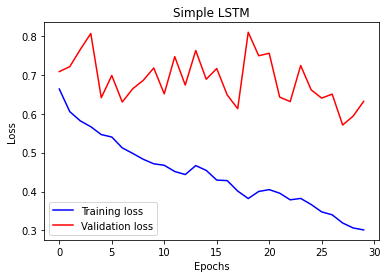

In [28]:
visualize_loss(history, "Simple LSTM")

Notice how the validation loss fluctuates wildly while the training loss decreases linearly. There are a variety of reasons this could be happening and it will really improve your test score if you can get to the bottom of this interesting training phenomenon.

## Create Submission

In [29]:
# Read in test data
X_test = pd.read_csv('Test.csv')

# Drop basket identifier
X_test.drop(['Basket Masked'], axis=1, inplace=True)

# Pop out ID
obs_id = X_test['ID'].drop_duplicates().reset_index(drop=True)
X_test.drop('ID', axis=1, inplace=True)

# Scale
X_test = scaler.transform(X_test)

# Prepare test set
X_test = block_data(X_test, 30)

# Predict
preds = model.predict(X_test, batch_size=64)

# Convert preds to class labels
submit = pd.DataFrame(obs_id)
submit['Target'] = preds

In [30]:
submit.head(10)

,ID,Target
0,ID_BE3ISV,0.005964
1,ID_5KDC05,0.030044
2,ID_V5QJBR,0.611420
3,ID_MA01DH,0.754912
4,ID_YG9C95,0.777319
5,ID_VMADJ9,0.012411
6,ID_BA64H7,0.355746
7,ID_0WG9ML,0.215915
8,ID_JT6V8N,0.846201
9,ID_Y3Z15X,0.669871


In [32]:
submit.to_csv('submission.csv', index = False)

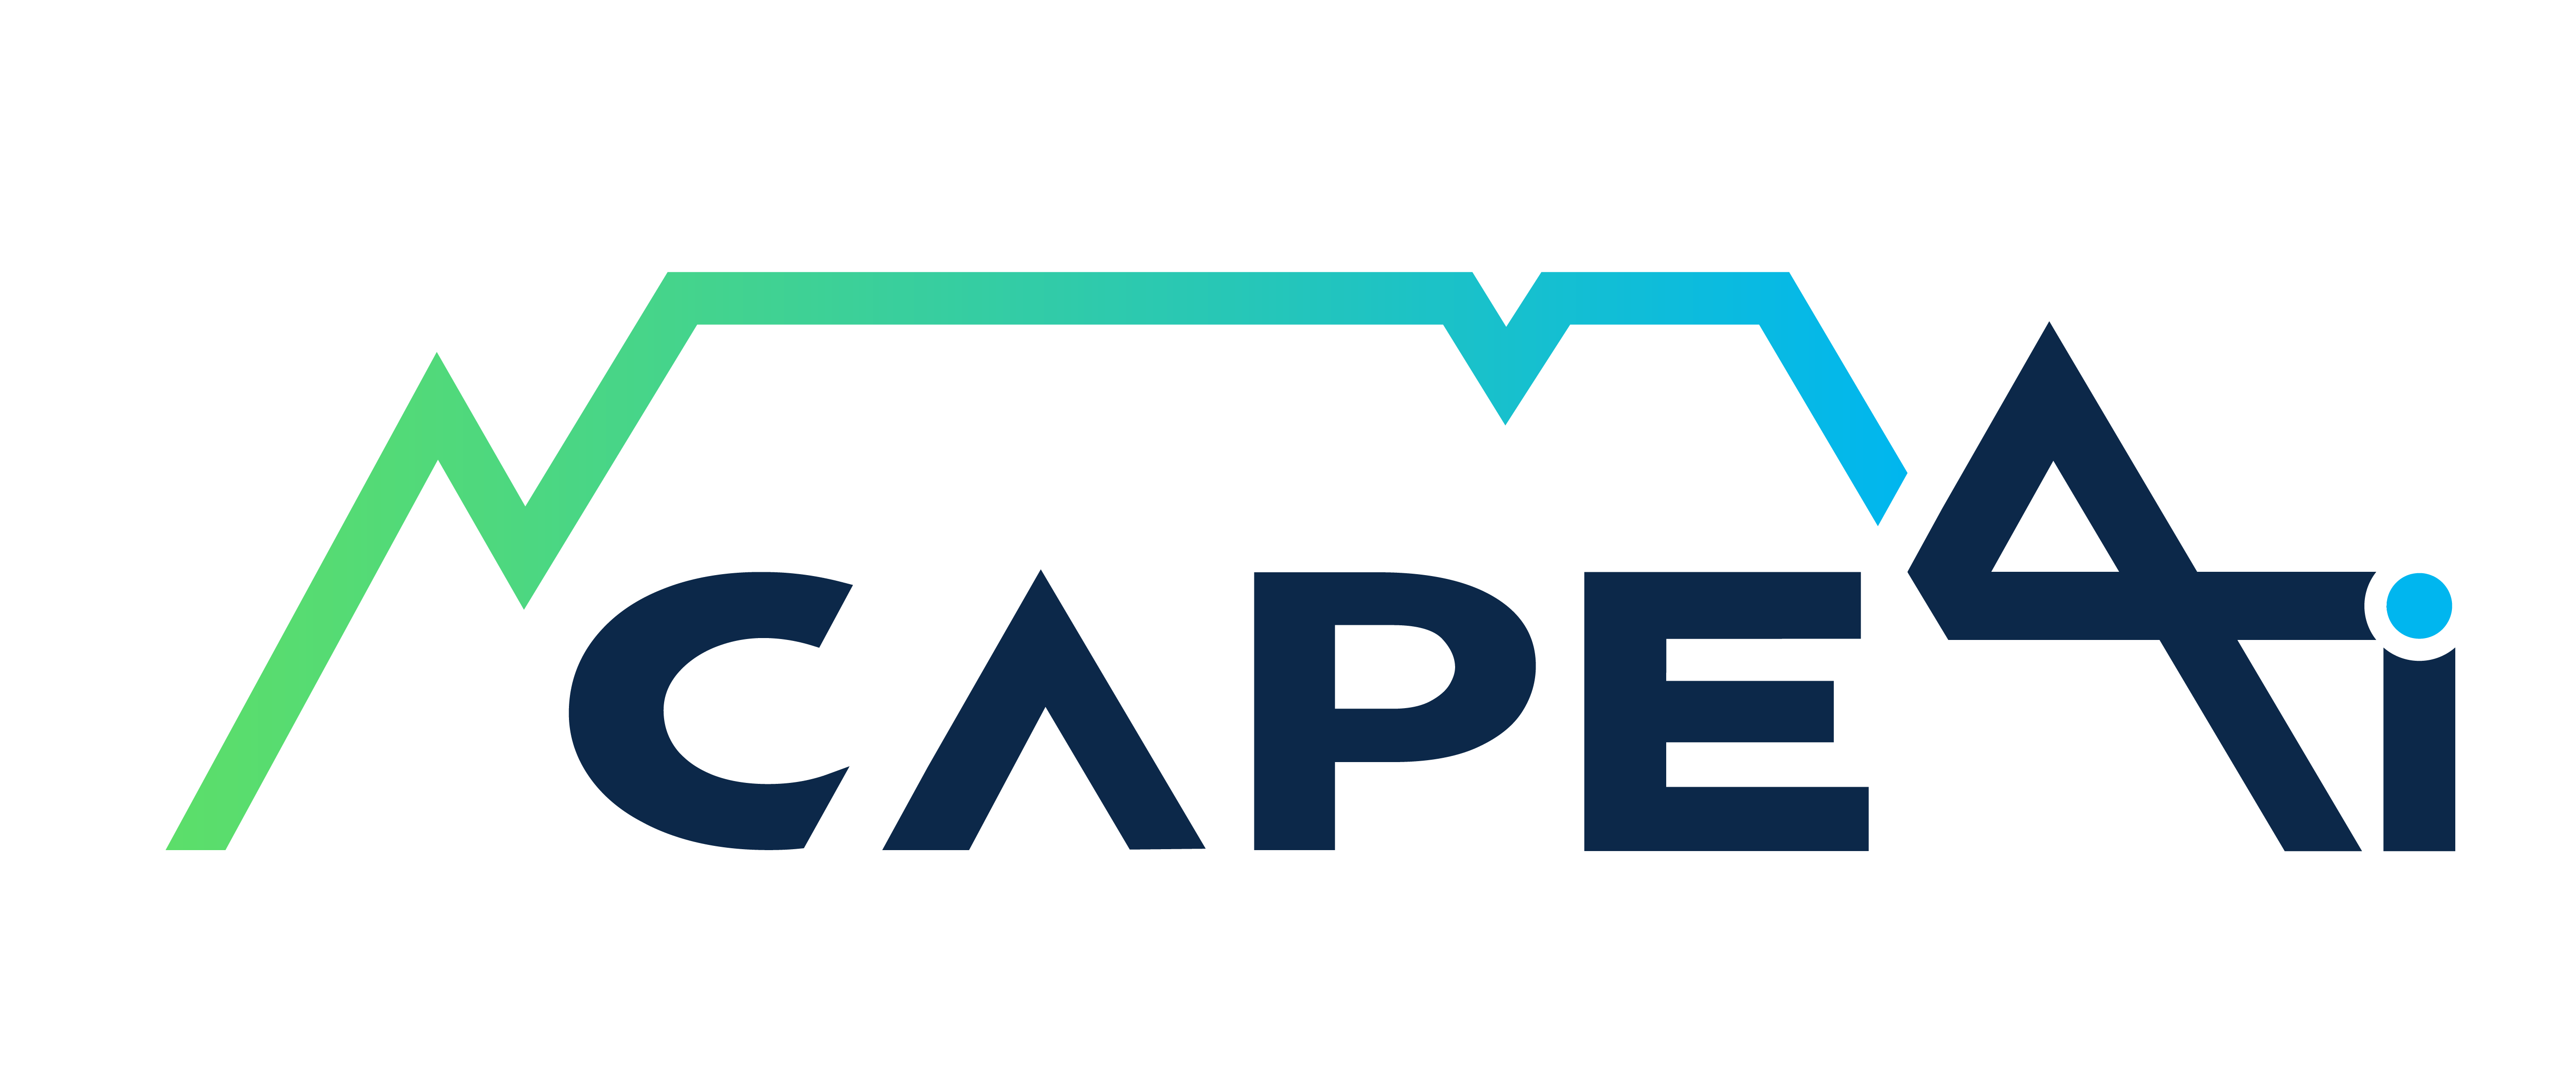